### Author
 - Gioele Modica

In [14]:
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
import os
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import matplotlib.animation as animation
from skimage.transform import resize
from skimage.filters import gaussian
from skimage import exposure
from skimage.filters import threshold_otsu
from skimage.morphology import ball, opening, closing, remove_small_objects, remove_small_holes
import SimpleITK as sitk
from scipy.ndimage import uniform_filter

# Functions

In [15]:
def load_dicom_series(directory):
    """Load a series of DICOM files from a directory and return as 3D numpy array"""
    files = [pydicom.dcmread(os.path.join(directory, f)) for f in sorted(os.listdir(directory))]
    slices = [f.pixel_array for f in files]
    return np.stack(slices, axis=0)

def load_single_dicom(filepath):
    """Load a single DICOM file"""
    ds = pydicom.dcmread(filepath)
    return ds.pixel_array

In [16]:
def extract_bounding_box(mask_volume):
    """Extract 3D bounding box coordinates from a binary mask volume"""
    labeled = label(mask_volume)
    props = regionprops(labeled)
    
    if len(props) == 0:
        return None
        
    bbox = props[0].bbox  # (min_z, min_y, min_x, max_z, max_y, max_x)
    return {
        'z_start': bbox[0],
        'z_end': bbox[3],
        'y_start': bbox[1],
        'y_end': bbox[4],
        'x_start': bbox[2],
        'x_end': bbox[5]
    }

In [17]:
def plot_slice_with_bbox(image_slice, mask_slice=None, bbox_coords=None, title=None):
    """Plot slice with mask and bounding box rectangle"""
    plt.figure(figsize=(10, 5))
    plt.imshow(image_slice, cmap='gray')
    
    if mask_slice is not None:
        mask_slice = np.ma.masked_where(mask_slice == 0, mask_slice)
        plt.imshow(mask_slice, cmap='autumn', alpha=0.3, label='Tumor Mask')
    
    if bbox_coords is not None:
        # Draw bounding box rectangle
        width = bbox_coords['x_end'] - bbox_coords['x_start']
        height = bbox_coords['y_end'] - bbox_coords['y_start']
        rect = plt.Rectangle((bbox_coords['x_start'], bbox_coords['y_start']),
                            width, height,
                            linewidth=2, edgecolor='lime', 
                            facecolor='none', label='Bounding Box')
        plt.gca().add_patch(rect)
    
    if title:
        plt.title(title)
    plt.legend()
    plt.show()

In [18]:
def crop_to_bbox(volume, bbox):
    """Crop a 3D volume to bounding box dimensions"""
    return volume[bbox['z_start']:bbox['z_end'],
                bbox['y_start']:bbox['y_end'],
                bbox['x_start']:bbox['x_end']]

In [19]:
def region_growing_segmentation(image_volume, seed_point,
                                threshold=20, bbox=None,
                                gradient_thresh=10,
                                var_thresh=0.01,  
                                max_radius=30, max_voxels=50000):
    """Perform region growing segmentation on a 3D image volume."""

    gradient_magnitude = np.sqrt(sum(g**2 for g in np.gradient(image_volume)))
    # Calculate local variance
    mean1 = uniform_filter(image_volume, size=3)
    mean2 = uniform_filter(image_volume**2, size=3)
    local_var = mean2 - mean1**2

    if isinstance(seed_point, dict):
        seed_point = (seed_point['z'], seed_point['y'], seed_point['x'])
    seed_arr = np.array(seed_point, int)

    segmented = np.zeros_like(image_volume, bool)
    to_visit = [seed_point]

    while to_visit:
        z,y,x = to_visit.pop(0)
        if segmented[z,y,x]:
            continue

        if bbox:
            z0,z1 = bbox['z_start'], bbox['z_end']
            y0,y1 = bbox['y_start'], bbox['y_end']
            x0,x1 = bbox['x_start'], bbox['x_end']
            if not (z0 <= z <= z1 and y0 <= y <= y1 and x0 <= x <= x1):
                continue
            
        # Check if the voxel is within the image volume
        th = threshold[z] if isinstance(threshold, dict) else threshold
        if image_volume[z,y,x] < th:
            continue

        # Check if the voxel is within the local variance threshold
        if local_var[z,y,x] > var_thresh:
            continue

        # spatial stop
        if np.linalg.norm(np.array([z, y, x]) - seed_arr) > max_radius:
            continue
        if gradient_magnitude[z,y,x] > gradient_thresh:
            continue

        # voxel count stop
        if segmented.sum() >= max_voxels:
            return segmented

        segmented[z, y, x] = True

        # enqueue integer neighbors
        for dz, dy, dx in [(1,0,0),(-1,0,0),(0,1,0),(0,-1,0),(0,0,1),(0,0,-1)]:
            nz, ny, nx = z + dz, y + dy, x + dx
            if 0 <= nz < image_volume.shape[0] and 0 <= ny < image_volume.shape[1] and 0 <= nx < image_volume.shape[2]:
                to_visit.append((int(nz), int(ny), int(nx)))

    return segmented


In [20]:
def compare_masks(ground_truth, predicted):
    """Compare two binary masks and calculate Dice and Jaccard coefficients"""
    # Check if the shapes of the masks are the same
    if ground_truth.shape != predicted.shape:
        # Find the minimum dimensions
        min_z = min(ground_truth.shape[0], predicted.shape[0])
        min_y = min(ground_truth.shape[1], predicted.shape[1])
        min_x = min(ground_truth.shape[2], predicted.shape[2])
        
        # Crop the masks to the minimum dimensions
        gt_cropped = ground_truth[:min_z, :min_y, :min_x]
        pred_cropped = predicted[:min_z, :min_y, :min_x]
    else:
        gt_cropped = ground_truth
        pred_cropped = predicted
    
    # Calculate Dice and Jaccard coefficients
    intersection = np.logical_and(gt_cropped, pred_cropped)
    union = np.logical_or(gt_cropped, pred_cropped)
    
    dice = 2 * intersection.sum() / (gt_cropped.sum() + pred_cropped.sum())
    jaccard = intersection.sum() / union.sum()
    
    return {
        'dice': dice,
        'jaccard': jaccard,
        'voxel_accuracy': (gt_cropped == pred_cropped).mean()
    }

In [21]:
def postprocess_segmentation(segmented):
    """Post-process the segmentation result to remove small objects and holes."""
    # closing + opening
    struct = ball(2) 
    seg = closing(segmented, struct)
    seg = opening(seg, struct)

    
    seg = remove_small_objects(seg, min_size=1000)
    seg = remove_small_holes(seg, area_threshold=1000)

    # keep only the largest connected component
    labels = label(seg)
    props = regionprops(labels)
    if props:
        largest = max(props, key=lambda p: p.area).label
        seg = (labels == largest)

    return seg


In [22]:
def plot_slice_with_masks(image_slice, gt_mask=None, pred_mask=None, title=None):
    """Plot a single slice with optional ground truth and predicted masks overlay"""
    plt.figure(figsize=(10, 5))
    
    plt.imshow(image_slice, cmap='gray')
    
    if gt_mask is not None:
        gt_mask = np.ma.masked_where(gt_mask == 0, gt_mask)
        plt.imshow(gt_mask, cmap='autumn', alpha=0.3, label='Ground Truth')
    
    if pred_mask is not None:
        pred_mask = np.ma.masked_where(pred_mask == 0, pred_mask)
        plt.imshow(pred_mask, cmap='winter', alpha=0.3, label='Predicted')
    
    if title:
        plt.title(title)
    
    plt.legend()
    plt.show()

In [23]:
def plot_multiplanar_slices(volume, mask, cross_coords=None):
    """
    Plot axial, sagittal and coronal slices with mask overlay in a 1x3 grid,
    resizing sagittal and coronal to match the axial slice dimensions.
    """
    # Get the seed slice indices
    z, y, x = cross_coords['z'], cross_coords['y'], cross_coords['x']

    # Extract the three raw views
    axial_img, axial_msk     = volume[z],       mask[z]
    sagittal_img, sagittal_msk = volume[:, :, x], mask[:, :, x]
    coronal_img, coronal_msk   = volume[:, y, :], mask[:, y, :]

    # Target shape = shape of the axial slice (height, width)
    target_shape = axial_img.shape

    # Resize sagittal & coronal to target_shape
    sagittal_img_rs = resize(sagittal_img, target_shape, preserve_range=True, anti_aliasing=True)
    sagittal_msk_rs = resize(sagittal_msk, target_shape, preserve_range=True, anti_aliasing=False) > 0.5

    coronal_img_rs = resize(coronal_img, target_shape, preserve_range=True, anti_aliasing=True)
    coronal_msk_rs = resize(coronal_msk, target_shape, preserve_range=True, anti_aliasing=False) > 0.5

    # Build ordered dict of views
    views = {
        'Axial':    (axial_img, axial_msk),
        'Sagittal': (sagittal_img_rs, sagittal_msk_rs),
        'Coronal':  (coronal_img_rs, coronal_msk_rs)
    }

    # Create 1x3 figure with equal aspect
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'aspect': 'equal'})

    for ax, (title, (img, msk)) in zip(axes, views.items()):
        ax.imshow(img, cmap='gray', interpolation='nearest')
        ax.imshow(
            np.ma.masked_where(msk == 0, msk),
            cmap='jet', alpha=0.3, interpolation='nearest'
        )
        ax.set_title(f"{title} slice")
        ax.axis('off')

    fig.tight_layout()
    plt.show()


In [24]:
def animate_slices(volume, mask, axis=0):
    """
    Generate and display an inline animation of overlay slices along given axis.
    """
    # number of slices along the chosen axis
    num_slices = volume.shape[axis]
    # show only the first 10 slices
    num_slices = min(num_slices, 10)

    # Prepare figure
    fig, ax = plt.subplots(figsize=(6, 6))

    def update(frame):
        ax.clear()
        # Select the correct slice
        if axis == 0:
            img, msk = volume[frame], mask[frame]
        elif axis == 1:
            img, msk = volume[:, frame, :], mask[:, frame, :]
        else:
            img, msk = volume[:, :, frame], mask[:, :, frame]

        # Plot background CT and overlay mask
        ax.imshow(img, cmap='gray')
        ax.imshow(np.ma.masked_where(msk == 0, msk), cmap='jet', alpha=0.3)
        ax.set_title(f"Slice {frame}")
        ax.axis('off')

    # Create the animation
    anim = animation.FuncAnimation(
        fig, update, frames=num_slices, interval=200, blit=False
    )

    # Display inline (HTML5 video)
    display(HTML(anim.to_jshtml()))

    # Close the figure to avoid duplicate static output
    plt.close(fig)

In [25]:
def exec():
    """Main function to execute the segmentation pipeline."""
    # Load reference image and tumor mask
    reference_volume = load_dicom_series('1493/30_EQP_Ax5.00mm')
    tumor_mask = load_single_dicom('1493/30_EQP_Ax5.00mm_ManualROI_Tumor.dcm')

    # Convert the reference volume to SimpleITK image
    sitk_img = sitk.GetImageFromArray(reference_volume)

    # Convert the tumor mask to SimpleITK image
    sitk_img = sitk.Cast(sitk_img, sitk.sitkFloat32)

    # Create a mask using Otsu's method
    mask_otsu = sitk.OtsuThreshold(sitk_img, 0, 1)

    # Apply N4 bias field correction
    n4 = sitk.N4BiasFieldCorrectionImageFilter()
    sitk_corrected = n4.Execute(sitk_img, mask_otsu)

    # Convert the corrected image back to numpy array
    reference_volume = sitk.GetArrayFromImage(sitk_corrected)

    reference_volume = (reference_volume - reference_volume.min()) / (reference_volume.max() - reference_volume.min())

    # Verify data loading
    print(f"Reference volume shape: {reference_volume.shape}")
    print(f"Tumor mask shape: {tumor_mask.shape}")
    # Extract bounding box & compute global seed
    bbox = extract_bounding_box(tumor_mask)
    seed_point = {
        'z': (bbox['z_start'] + bbox['z_end']) // 2,
        'y': (bbox['y_start'] + bbox['y_end']) // 2,
        'x': (bbox['x_start'] + bbox['x_end']) // 2
    }

    # 1. Derive sub-volume seed and crop image+mask
    seed_subvol = {
        'z': seed_point['z'] - bbox['z_start'],
        'y': seed_point['y'] - bbox['y_start'],
        'x': seed_point['x'] - bbox['x_start']
    }
    subvol = crop_to_bbox(reference_volume, bbox)
    tumor_mask_subvol = crop_to_bbox(tumor_mask,       bbox)

    # 2. Compute Otsu threshold per subvol slice
    th_per_slice = {
        z: threshold_otsu(subvol[z])
        for z in range(subvol.shape[0])
    }

    # 3. Preprocess sub-volume
    subvol = gaussian(subvol, sigma=1, preserve_range=True)
    subvol = np.stack(
        [exposure.equalize_hist(subvol[z]) for z in range(subvol.shape[0])],
        axis=0
    )

    # 4. Segment & post-process on sub-volume
    segmented       = region_growing_segmentation(subvol, seed_subvol,
                                                  threshold=th_per_slice,
                                                  bbox=None,
                                                  gradient_thresh=10)
    segmented_clean = postprocess_segmentation(segmented)

    # 5. Metrics on cropped mask
    metrics_raw   = compare_masks(tumor_mask_subvol, segmented)
    metrics_clean = compare_masks(tumor_mask_subvol, segmented_clean)

    print("\nMetrics BEFORE post-processing:")
    print(f"Dice: {metrics_raw['dice']:.3f}, Jaccard: {metrics_raw['jaccard']:.3f}")
    print("\nMetrics AFTER post-processing:")
    print(f"Dice: {metrics_clean['dice']:.3f}, Jaccard: {metrics_clean['jaccard']:.3f}")

    # Visualization at subvol centroid
    z0 = seed_subvol['z']
    plot_slice_with_masks(subvol[z0],
                          gt_mask=tumor_mask_subvol[z0],
                          pred_mask=segmented[z0],
                          title=f"Raw (Dice: {metrics_raw['dice']:.3f})")
    plot_slice_with_masks(subvol[z0],
                          gt_mask=tumor_mask_subvol[z0],
                          pred_mask=segmented_clean[z0],
                          title=f"Clean (Dice: {metrics_clean['dice']:.3f})")

    # Animate sub-volume only
    animate_slices(subvol, segmented_clean, axis=0)

# Execution

Reference volume shape: (58, 512, 512)
Tumor mask shape: (11, 512, 512)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Metrics BEFORE post-processing:
Dice: 0.424, Jaccard: 0.269

Metrics AFTER post-processing:
Dice: 0.477, Jaccard: 0.313


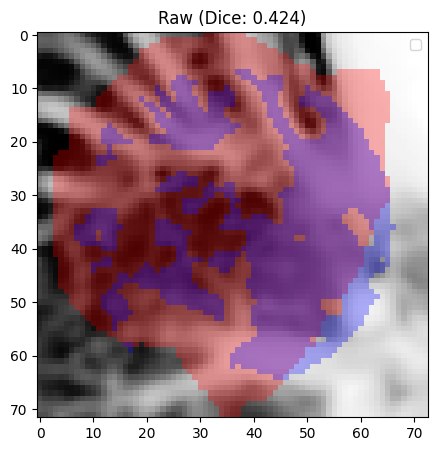

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


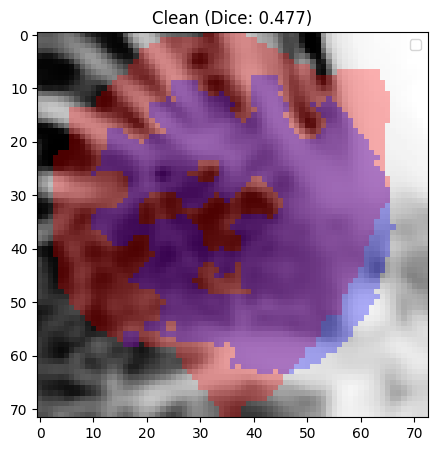

In [26]:
exec()